### SALES FORECAST PROJECT

USING GENERATED DATA SETS, WE WOULD IMPLORE OUR MACHINE LEARNING ALGORITHM TO ANALYSE OUR SALES RECORD AND TO PREDICT/FORECAST FUTURE SALES USING THE AVAILABLE DATA 

Loading the important and necessary libraries

In [1]:
import pandas as pd
import datetime                                        # To handle dates
import calendar                                        # To get month
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics                      # To get regression metrics
import scipy as sp
import time                                            # To do time complexity analysis
import random
import copy
import profile
import cProfile
from sklearn.cluster import KMeans                     # perform clustering operation
%matplotlib inline

READING OUR DATA and VIEWING IT'S CONTENTS AND DETAILS

In [2]:
#loading in raw data
features_df = pd.read_csv("features.csv")
stores_df = pd.read_csv("stores.csv")
train_df = pd.read_csv("train.csv")

In [3]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
stores_df.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [6]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
# # Creating a custom season dictionary to identify the season in each month
# seasons_dict = {
#     1:"Winter",
#     2:"Winter",
#     3:"Spring",
#     4:"Spring",
#     5:"Spring",
#     6:"Summer",
#     7:"Summer",
#     8:"Summer",
#     9:"Fall",
#     10:"Fall",
#     11:"Fall",
#     12:"Winter"
# }

In [8]:
# Creating the master dataset
master_df = train_df.merge(stores_df, on='Store', how='left')
master_df = master_df.merge(features_df, on=['Store', 'Date'], how='left')

### CLEANING OUR DATA SET

In [9]:
# Filling empty markdown columns
master_df['MarkDown1'] = master_df['MarkDown1'].fillna(0)
master_df['MarkDown2'] = master_df['MarkDown2'].fillna(0)
master_df['MarkDown3'] = master_df['MarkDown3'].fillna(0)
master_df['MarkDown4'] = master_df['MarkDown4'].fillna(0)
master_df['MarkDown5'] = master_df['MarkDown5'].fillna(0)

# Cleaning holiday columns
master_df['isHoliday'] = master_df['IsHoliday_x']
master_df = master_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])

In [10]:
# Handling Date and time
master_df['Date'] = pd.to_datetime(master_df['Date'], format='%Y-%m-%d')
master_df['Week_Number'] = master_df['Date'].dt.week
master_df['Quarter'] = master_df['Date'].dt.quarter
master_df['Month'] = master_df['Date'].dt.month.apply(lambda x: calendar.month_abbr[x])
master_df['Season'] = (master_df['Date'].apply(lambda dt: (dt.month%12 + 3)//3)).map(seasons_dict)
master_df["Year"] = master_df["Date"].dt.year

In [12]:
master_df=master_df.sort_values(by=['Store', 'Dept', 'Year', 'Week_Number'], ascending=True)    

# Previous week sales
shifted_sales = master_df.shift(1)
master_df_new_var = master_df.join(shifted_sales[['Store', 'Dept', 'Week_Number', 'Weekly_Sales', 'Year']], rsuffix='_Lag')
master_df_new_var.loc[(master_df_new_var.Dept != master_df_new_var.Dept_Lag) |  (master_df_new_var.Store != master_df_new_var.Store_Lag), 'Weekly_Sales_Lag'] = -2

##### CREATING DUMMY VARIABLES TO REPRESENT THE CATEGORICAL VALUES

In [13]:
#forming categorarical variables
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Quarter'], prefix='Quarter'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Season'], prefix='Season'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Store'], prefix='Store'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Dept'], prefix='Dept'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Type'], prefix='Type'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Week_Number'], prefix='Week_Number'))

In [14]:
# Removing wrongly recorded data points
master_df_new_var = master_df_new_var.dropna()
#master_df_new_var = master_df_new_var.loc[master_df_new_var['Week_Number'] > 4]
#master_df_new_var = master_df_new_var.loc[master_df_new_var['Monthly_Sales_Lag'] > 0]
master_df_new_var = master_df_new_var.loc[master_df_new_var['Weekly_Sales_Lag'] > 0]
master_df_new_var = master_df_new_var.loc[master_df_new_var['Weekly_Sales'] > 0] #keeping points which are only positive in value for the sales

In [15]:
master_df_new_var['MarkDown'] = master_df_new_var['MarkDown1'] + master_df_new_var['MarkDown2'] + master_df_new_var['MarkDown3'] + master_df_new_var['MarkDown4'] + master_df_new_var['MarkDown5']
master_df_new_var['MarkDown*Weekly_Sales_Lag'] = master_df_new_var['MarkDown']*master_df_new_var['Weekly_Sales_Lag']

BUILDING THE MODEL

In [16]:
#segregating the data
data_test = master_df_new_var[master_df_new_var.Year == 2012]
data_train = master_df_new_var[master_df_new_var.Year != 2012]

In [17]:
#Building full model linear regression
features = list(master_df_new_var)
for x in ('Quarter',
 'Month',
 'Season',
 'Year',
 'Store',
 'Dept',
 'Date',
 'Type',
 'Weekly_Sales',
 'Weekly_Sales_Lag'):
    features.remove(x)
#features

In [18]:
# Writing the formula
equals_to_str = ""
for i in features:
    equals_to_str = equals_to_str + str(i) + " + "

equals_to_str = str('Weekly_Sales ~ ') + equals_to_str
equals_to_str = equals_to_str[:-3] 
equals_to_str_promotion = equals_to_str + "Markdown1"

In [19]:
result_fullmodel = sm.ols(formula=equals_to_str, data = data_train).fit()
print("Model 1 without Promotion \n",result_fullmodel.summary())

Model 1 without Promotion 
                             OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 1.301e+04
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:25:46   Log-Likelihood:            -2.9899e+06
No. Observations:              289299   AIC:                         5.980e+06
Df Residuals:                  289109   BIC:                         5.982e+06
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


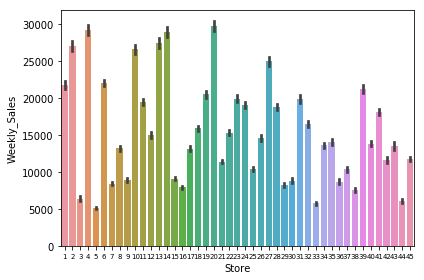

In [45]:
ax= sns.barplot(x="Store", y="Weekly_Sales",  data=master_df_new_var)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

#The graph below shows the relative variation in average weekly sales for different stores in Walmar

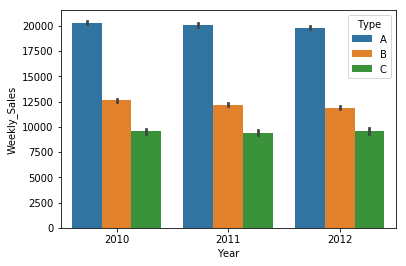

In [46]:
sns.barplot(x="Year", y="Weekly_Sales", hue="Type", data=master_df)

#In the above chart we can see the variation in the average sales of type A, type B, and type C stores. Type A store have the highest average sales.

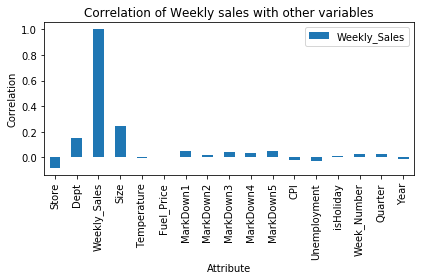

In [48]:
df_corr = master_df.corr()
ax=df_corr[['Weekly_Sales']].plot(kind='bar')
plt.xlabel('Attribute')
plt.ylabel('Correlation')
plt.title('Correlation of Weekly sales with other variables')
plt.tight_layout()
plt.show()

#From the correlation matrix we can see that many factors in the original dataset had week correlation with weekly sales. Therefore, to better explain the weekly sales we have identified new variables like weekly lag and yearly lag which provides a robust time series trend analysis for the future sales

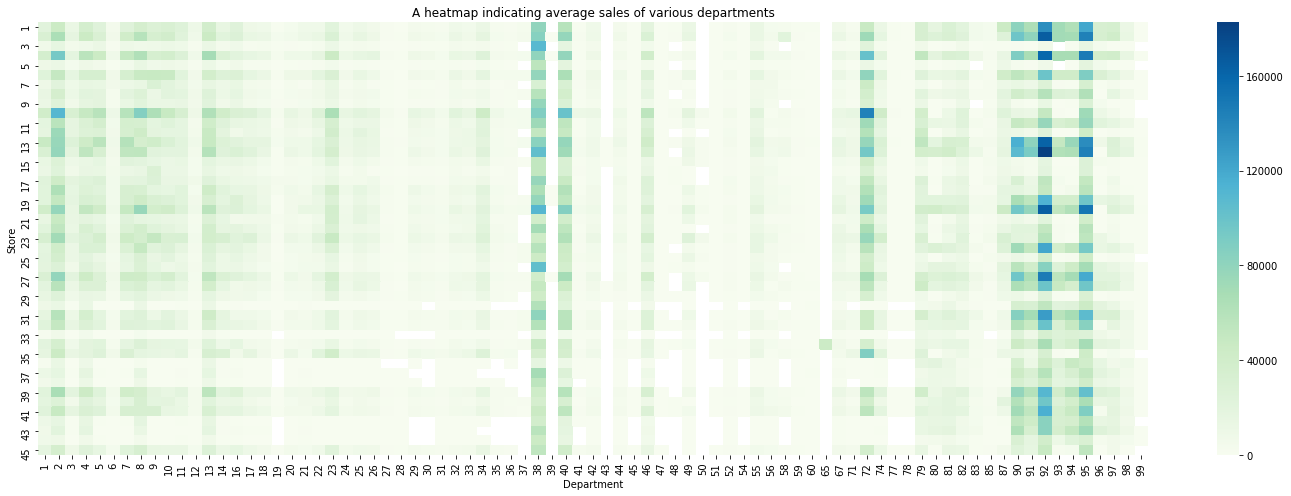

In [51]:
heat_df= master_df[['Store','Dept','Weekly_Sales']]
heat_map=heat_df.groupby(['Store','Dept']).mean()
heat_map.reset_index(inplace=True)
heat_map=heat_map.pivot('Store','Dept','Weekly_Sales')
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(heat_map, cmap="GnBu", ax=ax)
plt.xlabel('Department')
plt.ylabel('Store')
plt.title('A heatmap indicating average sales of various departments')
plt.tight_layout()
plt.show()

#The above heatmap helped us in augmenting our decision of including critical departments like 92, 95, and 38 in our regression equation

In [24]:
result_withoutpromotion = sm.ols(formula=equals_to_str, data = data_train).fit()
print("Model 1 without Promotion \n",result_withoutpromotion.summary())

Model 1 without Promotion 
                             OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 1.301e+04
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:27:57   Log-Likelihood:            -2.9899e+06
No. Observations:              289299   AIC:                         5.980e+06
Df Residuals:                  289109   BIC:                         5.982e+06
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

### VS

In [26]:
features = ['isHoliday', 'Temperature', 'Weekly_Sales_Lag']#, 'Size', 'MarkDown5', 'master_df_new_var']
features.extend(master_df_new_var.columns[master_df_new_var.columns.str.startswith('Type')])
features.remove('Type')

In [27]:
equals_to_str = ""

for i in features:
    equals_to_str = equals_to_str + str(i) + " + "

equals_to_str = str('Weekly_Sales ~ ') + equals_to_str
equals_to_str = equals_to_str  + 'Week_Number_50 + Week_Number_51+ Dept_95 + Dept_92+ Dept_38'
equals_to_str_withpromotion = equals_to_str  + '+ MarkDown*Weekly_Sales_Lag'

In [28]:
result_withpromotion = sm.ols(formula=equals_to_str_withpromotion, data = data_train).fit()
print("Model 1 with Promotion \n",result_withpromotion.summary())

Model 1 with Promotion 
                             OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 1.822e+05
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:29:42   Log-Likelihood:            -3.0052e+06
No. Observations:              289299   AIC:                         6.010e+06
Df Residuals:                  289286   BIC:                         6.010e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [29]:
data_test = pd.concat([data_test, result_withoutpromotion.predict(data_test).rename("predicted_values_withoutpromotion")], axis=1)
print('The accuracy of the model is', round((1-(metrics.median_absolute_error(data_test.predicted_values_withoutpromotion, data_test.Weekly_Sales)/data_test.Weekly_Sales.median()))*100, 2), '%.(in the test dataset)')
data_train = pd.concat([data_train, result_withoutpromotion.predict(data_train).rename("predicted_values_withoutpromotion")], axis=1)
print('The accuracy of the model is', round((1-(metrics.median_absolute_error(data_train.predicted_values_withoutpromotion, data_train.Weekly_Sales)/data_train.Weekly_Sales.median()))*100, 2), '%.(in the train dataset)')

The accuracy of the model is 77.06 %.(in the test dataset)
The accuracy of the model is 82.04 %.(in the train dataset)


#### RESULTS VISUALIZATION

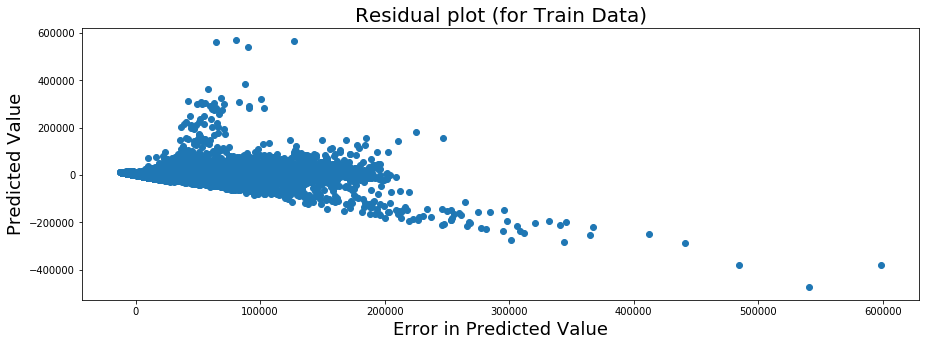

In [53]:
pred_val = result_withoutpromotion.fittedvalues.copy()
true_val = data_train['Weekly_Sales'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Error in Predicted Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Residual plot (for Train Data)", fontsize = 20)
_ = ax.scatter(pred_val, residual)

#From the residual plot for the train data we can see that the errors are farely random and we do not see any clear pattern among the residuals. Therefore, we can say that our linear regression does not have any heteroscedasticity

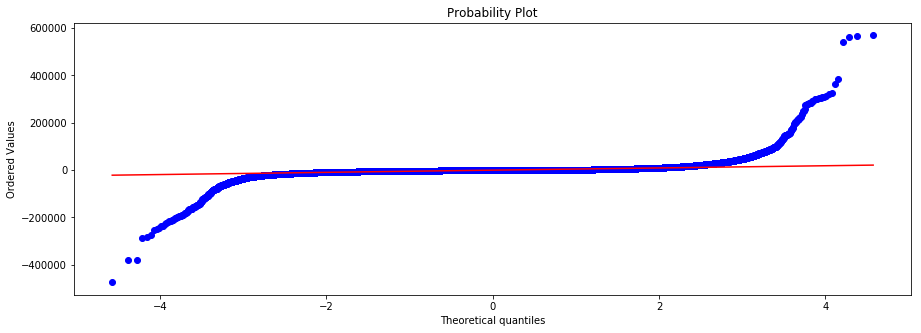

In [54]:
fig, ax = plt.subplots(figsize=(15,5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
#r**2

#The probability plot indicates that the residuals are normally distributed

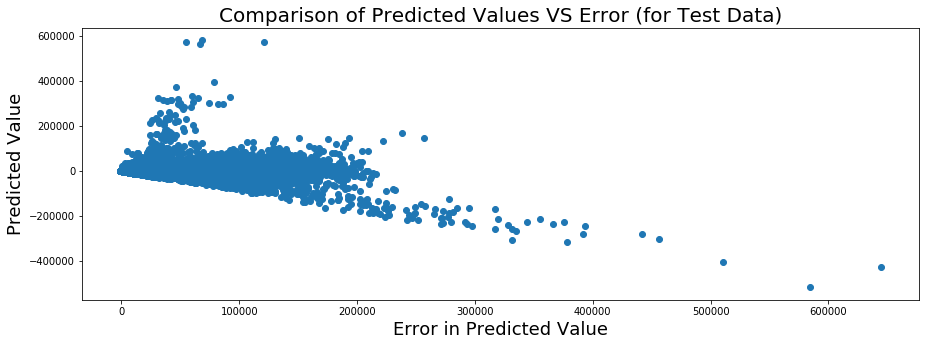

In [32]:
pred_val = result_withpromotion.fittedvalues.copy()
true_val = data_train['Weekly_Sales'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Error in Predicted Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Comparison of Predicted Values VS Error (for Test Data)", fontsize = 20)
_ = ax.scatter(pred_val, residual)

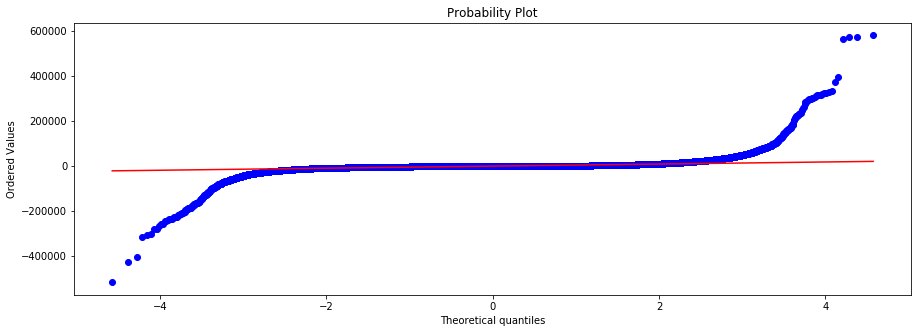

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
#r**2

In [34]:
data_test["predicted_values_withoutpromotion"] = result_withoutpromotion.predict(data_test)
data_test["predicted_values_withpromotion"] = result_withoutpromotion.predict(data_test)

actual_sales = data_test.groupby("Dept").mean()["Weekly_Sales"]
predicted_sales_withoutpromotion = data_test.groupby("Dept").mean()["predicted_values_withoutpromotion"]
#data_test.to_csv("predictedvsactual.csv")


Text(0.5, 1.0, 'Scatter plot of Actual Value VS Predicted Value')

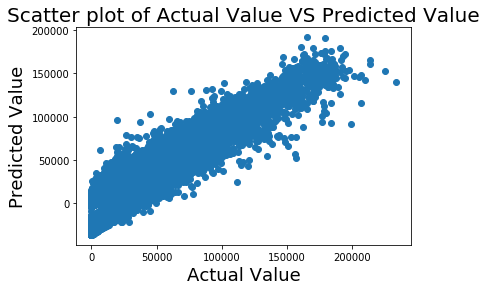

In [35]:
plt.scatter(data_test['Weekly_Sales'], data_test['predicted_values_withpromotion'])
plt.xlabel('Actual Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Scatter plot of Actual Value VS Predicted Value", fontsize = 20)


In [41]:
# To measure the time taken to execute the function
def measureTime(fun,arg1):
    nTimes=10
    times=np.zeros(nTimes)
    for i in range(nTimes):
        startTime = time.time()    
        fun(arg1)
        endTime = time.time()
        times[i]=endTime-startTime
    return np.mean(times)

In [42]:
# We use the model to predict the expected sales
def predict(total_obs):
    X = []
    y = []
    for obs in range(total_obs):
        i=random.randint(0, len(data_test))
        x=pd.DataFrame(data_test.iloc[i,:]).T[["isHoliday", "Temperature", "Weekly_Sales_Lag", "Type_A", "Type_B", "Type_C", "Week_Number_50", "Week_Number_51", "Dept_95", "Dept_92", "Dept_38"]]
        x=x.astype(int)
        X.append(x)
        predicted_value = result_withoutpromotion.predict(x)
        y.append(predicted_value)
    return (X, y)

In [56]:
cProfile.run('predict(10)')

#The majority of the time is spent on the length and assignment operations. Thus, these two function calling should be minimmized for increasing the efficiency.

         2706 function calls (2650 primitive calls) in 0.010 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       31    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
        4    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:416(parent)
        1    0.000    0.000    0.010    0.010 <ipython-input-42-9c27a63a20e1>:2(predict)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        3    0.000    0.000    0.000    0.000 __init__.py:205(iteritems)
        1    0.000    0.000    0.000    0.000 __init__.py:39(__init__)
        1    0.000    0.000    0.000    0.000 __init__.py:52(set_origin)
        1    0.000    0.000    0.000    0.000 _decorators.py:136(wrapper)
        8    0.000    0.000    0.000    0.000 _methods.py:42(_any)
        1    0.000    0.000    0.000    0.000 _methods.py:45(_all)
        9    0.000    0.000    0.000    0.000 abc.py:137(__i

        1    0.000    0.000    0.000    0.000 highlevel.py:225(dmatrix)
        1    0.000    0.000    0.000    0.000 highlevel.py:33(_try_incr_builders)
        1    0.000    0.000    0.000    0.000 indexing.py:1225(_convert_to_indexer)
        1    0.000    0.000    0.006    0.006 indexing.py:142(_get_loc)
        1    0.000    0.000    0.007    0.007 indexing.py:1463(__getitem__)
        3    0.000    0.000    0.000    0.000 indexing.py:1465(<genexpr>)
        2    0.000    0.000    0.000    0.000 indexing.py:1943(_validate_key)
        1    0.000    0.000    0.000    0.000 indexing.py:1976(_is_scalar_access)
        2    0.000    0.000    0.000    0.000 indexing.py:2003(_validate_integer)
        1    0.000    0.000    0.007    0.007 indexing.py:2011(_getitem_tuple)
        1    0.000    0.000    0.007    0.007 indexing.py:2075(_getitem_axis)
        1    0.000    0.000    0.000    0.000 indexing.py:216(_has_valid_tuple)
        1    0.000    0.000    0.000    0.000 indexing.py:228

        5    0.000    0.000    0.000    0.000 {method 'items' of 'collections.OrderedDict' objects}
        8    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {method 'keys' of 'dict' objects}
        4    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'pop' of 'list' objects}
        3    0.000    0.000    0.000    0.000 {method 'ravel' of 'numpy.ndarray' objects}
        9    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.000    0.000    0.000    0.000 {method 'reshape' of 'numpy.ndarray' objects}
        4    0.000    0.000    0.000    0.000 {method 'rpartition' of 'str' objects}
        1    0.000    0.000    0.000    0.000 {method 'take' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {method 'transpose' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.

PatsyError: Error evaluating factor: NameError: name 'Size' is not defined
    Weekly_Sales ~ Size + Temperature + Fuel_Price + MarkDown1 + MarkDown2 + MarkDown3 + MarkDown4 + MarkDown5 + CPI + Unemployment + isHoliday + Week_Number + Store_Lag + Dept_Lag + Week_Number_Lag + Year_Lag + Quarter_1 + Quarter_2 + Quarter_3 + Quarter_4 + Season_Spring + Season_Winter + Store_1 + Store_2 + Store_3 + Store_4 + Store_5 + Store_6 + Store_7 + Store_8 + Store_9 + Store_10 + Store_11 + Store_12 + Store_13 + Store_14 + Store_15 + Store_16 + Store_17 + Store_18 + Store_19 + Store_20 + Store_21 + Store_22 + Store_23 + Store_24 + Store_25 + Store_26 + Store_27 + Store_28 + Store_29 + Store_30 + Store_31 + Store_32 + Store_33 + Store_34 + Store_35 + Store_36 + Store_37 + Store_38 + Store_39 + Store_40 + Store_41 + Store_42 + Store_43 + Store_44 + Store_45 + Dept_1 + Dept_2 + Dept_3 + Dept_4 + Dept_5 + Dept_6 + Dept_7 + Dept_8 + Dept_9 + Dept_10 + Dept_11 + Dept_12 + Dept_13 + Dept_14 + Dept_16 + Dept_17 + Dept_18 + Dept_19 + Dept_20 + Dept_21 + Dept_22 + Dept_23 + Dept_24 + Dept_25 + Dept_26 + Dept_27 + Dept_28 + Dept_29 + Dept_30 + Dept_31 + Dept_32 + Dept_33 + Dept_34 + Dept_35 + Dept_36 + Dept_37 + Dept_38 + Dept_39 + Dept_40 + Dept_41 + Dept_42 + Dept_43 + Dept_44 + Dept_45 + Dept_46 + Dept_47 + Dept_48 + Dept_49 + Dept_50 + Dept_51 + Dept_52 + Dept_54 + Dept_55 + Dept_56 + Dept_58 + Dept_59 + Dept_60 + Dept_65 + Dept_67 + Dept_71 + Dept_72 + Dept_74 + Dept_77 + Dept_78 + Dept_79 + Dept_80 + Dept_81 + Dept_82 + Dept_83 + Dept_85 + Dept_87 + Dept_90 + Dept_91 + Dept_92 + Dept_93 + Dept_94 + Dept_95 + Dept_96 + Dept_97 + Dept_98 + Dept_99 + Type_A + Type_B + Type_C + Week_Number_1 + Week_Number_2 + Week_Number_3 + Week_Number_4 + Week_Number_5 + Week_Number_6 + Week_Number_7 + Week_Number_8 + Week_Number_9 + Week_Number_10 + Week_Number_11 + Week_Number_12 + Week_Number_13 + Week_Number_14 + Week_Number_15 + Week_Number_16 + Week_Number_17 + Week_Number_18 + Week_Number_19 + Week_Number_20 + Week_Number_21 + Week_Number_22 + Week_Number_23 + Week_Number_24 + Week_Number_25 + Week_Number_26 + Week_Number_27 + Week_Number_28 + Week_Number_29 + Week_Number_30 + Week_Number_31 + Week_Number_32 + Week_Number_33 + Week_Number_34 + Week_Number_35 + Week_Number_36 + Week_Number_37 + Week_Number_38 + Week_Number_39 + Week_Number_40 + Week_Number_41 + Week_Number_42 + Week_Number_43 + Week_Number_44 + Week_Number_45 + Week_Number_46 + Week_Number_47 + Week_Number_48 + Week_Number_49 + Week_Number_50 + Week_Number_51 + Week_Number_52 + MarkDown + MarkDown*Weekly_Sales_Lag
                   ^^^^

#### the end